# **Resources:**
- https://github.com/slundberg/shap
- H2O Explainability best practices: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb

Materials by Patrick Hall:
https://github.com/jphall663/interpretable_machine_learning_with_python
https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/debugging_resid_analysis_redux.ipynb   
Decision tree plotting: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb

## Preparation

In [1]:
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 

#Install shap package as needed:
#!pip uninstall numpy
#!pip uninstall numba
#!pip install shap==0.40.0

import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

try:
    h2o.cluster().shutdown()
except:
    pass 

/var/folders/hd/qln9g6n51snggb5qgwn55w9c0000gn/T/ipykernel_50243/3021516139.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=3, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,15 days 3 hours 30 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_aishwaryaadiki_plrork
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.060 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


### Load data

In [86]:
train = h2o.import_file('Car_Prices_Poland_train.csv')
test = h2o.import_file('Car_Prices_Poland_test.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [87]:
train.head(5)

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
opel,insignia,gen-a-2008-2017,2009,106125,1796,Gasoline,Częstochowa,Śląskie,25000
skoda,fabia,gen-ii-2007,2010,207000,1200,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900
opel,insignia,gen-a-2008-2017,2013,195000,1956,Diesel,Ruda Śląska,Śląskie,24598
audi,a4,gen-b8-2007-2015,2012,280000,1968,Diesel,Białystok,Podlaskie,41900
citroen,c4-picasso,gen-ii-2013-c4-picasso,2014,122200,1560,Diesel,Dziemionna,Kujawsko-pomorskie,39500


In [88]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (88445, 10)
Test shape: (29482, 10)


In [89]:
train.describe()

Rows:88445
Cols:10

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
type,enum,enum,enum,int,int,int,enum,enum,enum,int
mins,,,,1964.0,0.0,0.0,,,,500.0
mean,,,,2012.9334275538474,140832.0195488721,1812.3419074000792,,,,70347.49990389508
maxs,,,,2022.0,2800000.0,7600.0,,,,2399900.0
sigma,,,,5.684015918888885,92510.79953360025,646.7315007474649,,,,85275.90175596681
zeros,,,,0,283,936,,,,0
missing,0,0,22551,0,0,0,0,0,0,0
0,opel,insignia,gen-a-2008-2017,2009.0,106125.0,1796.0,Gasoline,Częstochowa,Śląskie,25000.0
1,skoda,fabia,gen-ii-2007,2010.0,207000.0,1200.0,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900.0
2,opel,insignia,gen-a-2008-2017,2013.0,195000.0,1956.0,Diesel,Ruda Śląska,Śląskie,24598.0


In [90]:
cat_columns = ["model","mark","generation_name","fuel", "city", "province"]
encoded_columns = cat_columns
other = ["year","mileage","vol_engine", "price"]
cat_train_df = train[encoded_columns].asfactor()
cat_test_df = test[encoded_columns].asfactor()

In [91]:
train = train.drop(cat_columns)
test = test.drop(cat_columns)

In [92]:
train = train.cbind(cat_train_df)
test = test.cbind(cat_test_df)

## **Trained H2O `H2OGradientBoostingEstimator` with parameters:**
```
nfolds=5,
ntrees=500,
stopping_rounds=5,
stopping_metric='MAE',
seed=1234,
keep_cross_validation_predictions = False
```
Display model performance on `test` dataset using `model_performance` function.

In [93]:
predictors = train.columns
predictors.remove("price")
print("Predictor columns:", predictors)    
response = "price"

Predictor columns: ['year', 'mileage', 'vol_engine', 'model', 'mark', 'generation_name', 'fuel', 'city', 'province']


In [94]:
from h2o.estimators import H2OGradientBoostingEstimator
gradientBoost = H2OGradientBoostingEstimator(nfolds=5, ntrees=500, stopping_rounds=5, stopping_metric='MAE', seed=1234, 
                                             keep_cross_validation_predictions = False)

gradientBoost.train(predictors, response, training_frame= train)
model_summary = gradientBoost.summary()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [95]:
model_summary

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,239.0,239.0,173991.0,5.0,5.0,5.0,9.0,32.0,20.309624


In [96]:
print("Model MAE:", gradientBoost.model_performance(test).mae())


Model MAE: 8382.516624791275


## **Permutation Importance:**

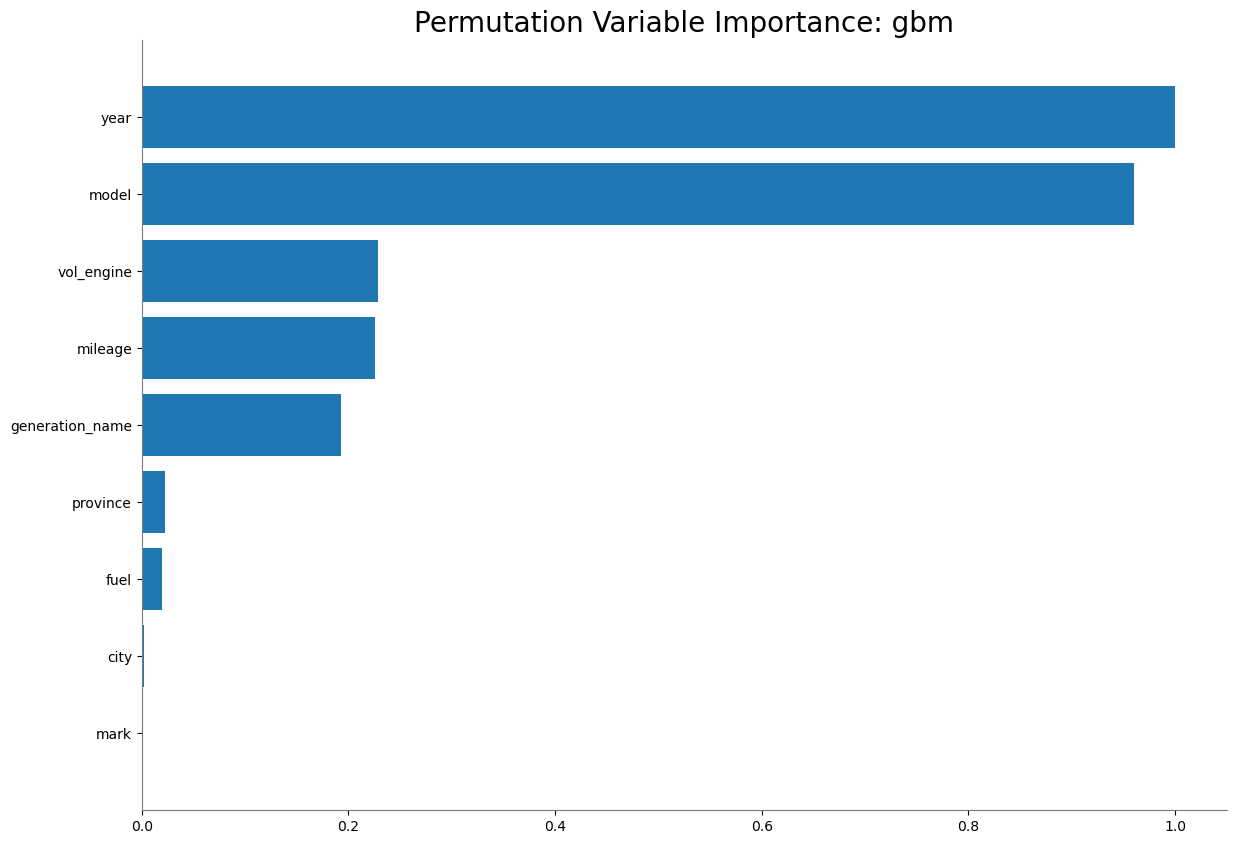

Variable,Relative Importance,Scaled Importance,Percentage
year,44462.5293823,1.0,0.3771895
model,42704.4001718,0.9604582,0.3622748
vol_engine,10173.0836620,0.2288013,0.0863014
mileage,10016.8205050,0.2252868,0.0849758
generation_name,8573.9168165,0.1928347,0.0727352
province,986.5586428,0.0221885,0.0083693
fuel,874.7776250,0.0196745,0.0074210
city,79.9477415,0.0017981,0.0006782
mark,6.4463523,0.0001450,0.0000547


In [97]:
gradientBoost.permutation_importance_plot(test)

#### **The most important feature is year, with a Scaled Feature importance of 1(obviously because it is scaled) and feature percentage of 0.3806983**
  
#### **Based on the information given, we can only tell how important a feature is. We cannot tell which direction the probablity of the feature would be**

# **Absolute Error:**

Calculated absolute error of the price on test dataset. Add absolute error column to the dataset and call it `abs_error`.   

Formula: `abs(price-predict_price)`

In [99]:
# Generate predictions on a test set:
pred_price = gradientBoost.predict(test)


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [100]:
test["abs_error"]= abs(test["price"]-pred_price)

In [101]:
test

year,mileage,vol_engine,price,model,mark,generation_name,fuel,city,province,abs_error
2016,63000,1598,49500,octavia,skoda,gen-iii-2013,Diesel,Szamotuły,Wielkopolskie,6659.85
1967,1,6384,379900,mustang,ford,,Gasoline,Łódź,Łódzkie,20169.1
2016,125600,1998,99800,cooper,mini,,Gasoline,Poznań,Wielkopolskie,27039
2014,270000,2199,59900,santa-fe,hyundai,gen-iii-2012-santa-fe,Diesel,Radziejów,Kujawsko-pomorskie,18503
2019,24000,999,56999,clio,renault,gen-v-2019,Gasoline,Leszno,Wielkopolskie,5432.66
2003,248000,2171,13900,seria-3,bmw,gen-e46-1998-2007,LPG,Świebodzice,Dolnośląskie,2370.14
2018,26500,1498,117500,tiguan,volkswagen,gen-ii-2016-tiguan,Gasoline,Swarzędz,Wielkopolskie,6006.1
1966,47522,4700,59900,mustang,ford,,Gasoline,Repki,Mazowieckie,57786.7
2021,7,0,160000,500,fiat,,Electric,Warszawa,Mazowieckie,22086
2021,10,1968,140046,caddy,volkswagen,gen-iv-2015,Diesel,Łódź,Łódzkie,7950.51


## **SHAPLEY PLOTS:**

#### What is the most important feature based on Shapley values?
  - **The most important features are year, mileage, and model**
#### Based on the Summary plot, how do features `year` and `mileage` affect model prediction of the car price?
  - **Year and mileage negatively affect the predicted car price**

In [54]:
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe)).as_data_frame().values
        return self.predictions.astype('float64')[:,-1] #probability of True class

In [55]:
feature_names = list(train.columns)
h2o_wrapper = H2OProbWrapper(gradientBoost,feature_names) 

In [73]:
test_df = h2o.as_list(test, use_pandas=True)
test_df = test_df.drop(columns = "price")
test_df

/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,year,mileage,vol_engine,abs_error,model,mark,generation_name,fuel,city,province
0,2016,63000,1598,7051.703228,octavia,skoda,gen-iii-2013,Diesel,Szamotuły,Wielkopolskie
1,1967,1,6384,28894.862953,mustang,ford,NaN,Gasoline,Łódź,Łódzkie
2,2016,125600,1998,26515.425018,cooper,mini,NaN,Gasoline,Poznań,Wielkopolskie
3,2014,270000,2199,19742.525717,santa-fe,hyundai,gen-iii-2012-santa-fe,Diesel,Radziejów,Kujawsko-pomorskie
4,2019,24000,999,5684.471633,clio,renault,gen-v-2019,Gasoline,Leszno,Wielkopolskie
...,...,...,...,...,...,...,...,...,...,...
29477,2018,115000,1500,11787.930789,mondeo,ford,gen-mk5-2014,Gasoline,Warszawa,Mazowieckie
29478,2002,189912,1595,2310.119605,octavia,skoda,gen-i-1996-2011,Gasoline,Gdańsk,Pomorskie
29479,2020,25800,1950,2800.029057,e-klasa,mercedes-benz,gen-w213-2016,Diesel,Straszyn,Pomorskie
29480,2018,127695,1598,5139.343161,octavia,skoda,gen-iii-2013,Diesel,Novy Jicin,Moravian-Silesian Region


In [74]:
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
Using 29482 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


███████████████████████████████████████████████████████| (done) 100%


# **SHAPLEY PLOTS CONTINUED:**

**Plotted individual Shapley values plots for records top 3 and bottom 3 records based on the residuals, for the total of 6 plots.** 

Explained each plot in terms of what are most influential features and how they impact model prediction, and why I think model was correct for the top 3 records (smallest residuals) and significantly incorrect for the bottom 3 records (largest residuals).


In [75]:
shap.initjs()
shap_values = explainer.shap_values(test_df.iloc[0], nsamples=50)
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[0])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Explanation for Record 0
The predicted price is $56,551.70. It seems that mileage and year negatively affect the sale price of the car (lowers the car value), and the model and vol_engine variables positively affect the current price/value of the car. Other features don't seem as important. Additionally, the predicted price is higher than the actual price of the car

--------------------------------------------------------------------------------------------------------

In [76]:
shap_values = explainer.shap_values(test_df.iloc[1], nsamples=50)
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[1])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Explanation for Record 1
The predicted price is $408,794.86 It seems that mileage, vol_engine, and model negatively affect the sale price of the Mustang car (lowers the car value). However, the predicted price is still higher than the actual price of USD 379900 which I think could be due to the fact that Mustang's are luxury cars and they appreciate and depreciate in value differently compared to normal cars. Other features don't seem as important.

--------------------------------------------------------------------------------------------------------

In [77]:
shap_values = explainer.shap_values(test_df.iloc[2], nsamples=50)
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[2])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Explanation for Record 2
The predicted price is $73,284.57 Year and vol_engine negatively affect the sale price of the car (lowers the car value). Unfortunately eventhough the missing generation_name adds some positive value, it is not enough to overcome stronger features such as the year and vol_engine.  As a result, the predicted price is less than the actual car price of USD 99,800 Other features don't seem as important.

--------------------------------------------------------------------------------------------------------

In [78]:
shap_values = explainer.shap_values(test_df.iloc[-1], nsamples=50)
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[-1])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [81]:
test.tail(5)

year,mileage,vol_engine,price,abs_error,model,mark,generation_name,fuel,city,province
2018,115000,1500,64900,11787.9,mondeo,ford,gen-mk5-2014,Gasoline,Warszawa,Mazowieckie
2002,189912,1595,6999,2310.12,octavia,skoda,gen-i-1996-2011,Gasoline,Gdańsk,Pomorskie
2020,25800,1950,259900,2800.03,e-klasa,mercedes-benz,gen-w213-2016,Diesel,Straszyn,Pomorskie
2018,127695,1598,71667,5139.34,octavia,skoda,gen-iii-2013,Diesel,Novy Jicin,Moravian-Silesian Region
2013,103120,1396,38000,5337.68,ix20,hyundai,,Gasoline,Bielany Wrocławskie,Dolnośląskie


### Explanation for Record -1 (last record)
The predicted price is $32,662.32. Year and vol_engine seem to positively affect the car price, which makes no sense since the car is old (2013). Additionally, mileage is missing from the shap plot, which is incorrect since mileage negatively affects car price. This makes the car depreciate less than it is supposed to.

--------------------------------------------------------------------------------------------------------

In [82]:
shap_values = explainer.shap_values(test_df.iloc[-2], nsamples=50)
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[-2])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Explanation for Record -2 (second to last record)
The predicted price is $66,527.66. Year is negatively affecting the car price. However, it seems that mileage is positively affecting the car price which doesn't make sense since the car has driven 127695 which should greatly lessen the value of the car. 

--------------------------------------------------------------------------------------------------------

In [83]:
shap_values = explainer.shap_values(test_df.iloc[-3], nsamples=50)
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[-3])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Explanation for Record -3 (third to last record)
The predicted price is $257,099; And the actual price of the car is 259900 USD. model is negatively affecting the car price along with generation_name which doesn't make sense since these features need to have a positive affect on car price.

--------------------------------------------------------------------------------------------------------

# **SURROGATE MODEL: GBM**

Trained new H2O GBM model on the test dataset trying to predict residuals. This was the surrogate model that was used to understand what features are driving high residuals.   

Used same parameters as in previous model, except:
  - target (response variable) is now "abs_error"
  - dataset now is "test" dataset
  - did not include original "price" column in the model

Plotted Shapley summary plot for the top 100 records with highest residuals.

In [102]:
from h2o.estimators import H2OGradientBoostingEstimator
response = "abs_error"
gradientBoost2 = H2OGradientBoostingEstimator(nfolds=5, ntrees=500, stopping_rounds=5, stopping_metric='MAE', seed=1234, 
                                             keep_cross_validation_predictions = False)

gradientBoost2.train(predictors, response, training_frame= test)
model_summary = gradientBoost.summary()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [103]:
model_summary

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,239.0,239.0,173991.0,5.0,5.0,5.0,9.0,32.0,20.309624


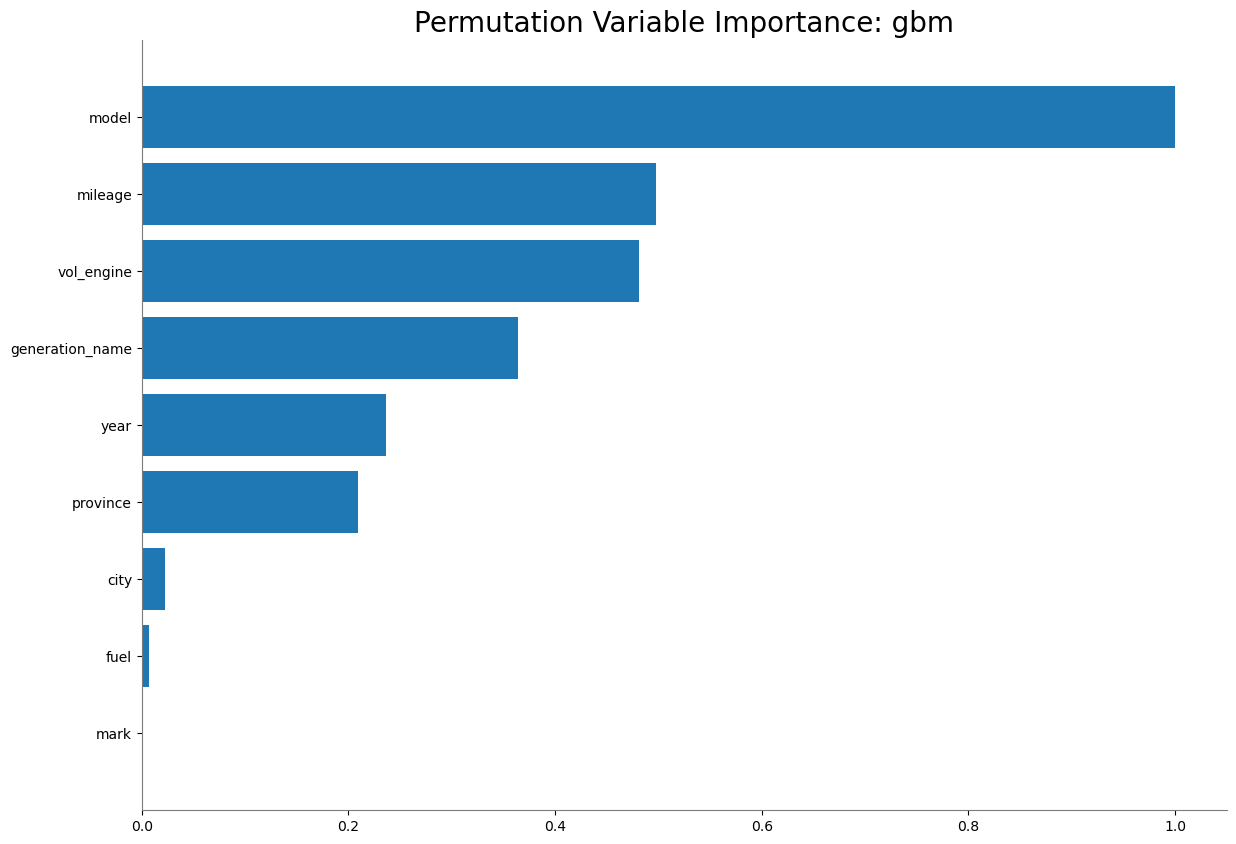

Variable,Relative Importance,Scaled Importance,Percentage
model,4873.7613091,1.0,0.3548210
mileage,2427.8222204,0.4981414,0.1767510
vol_engine,2344.7849915,0.4811038,0.1707057
generation_name,1774.6980406,0.3641331,0.1292021
year,1152.8620807,0.2365446,0.0839310
province,1018.5973369,0.2089961,0.0741562
city,108.4027455,0.0222421,0.0078920
fuel,34.9038332,0.0071616,0.0025411
mark,0.0,0.0,0.0


In [119]:
gradientBoost2.permutation_importance_plot(test)

In [104]:
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe)).as_data_frame().values
        return self.predictions.astype('float64')[:,-1] #probability of True class

In [116]:
test_df = h2o.as_list(test, use_pandas=True)
test_df = test_df.drop(columns = "price")
test_df

/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,year,mileage,vol_engine,model,mark,generation_name,fuel,city,province,abs_error
0,2016,63000,1598,octavia,skoda,gen-iii-2013,Diesel,Szamotuły,Wielkopolskie,6659.851777
1,1967,1,6384,mustang,ford,NaN,Gasoline,Łódź,Łódzkie,20169.066269
2,2016,125600,1998,cooper,mini,NaN,Gasoline,Poznań,Wielkopolskie,27038.993379
3,2014,270000,2199,santa-fe,hyundai,gen-iii-2012-santa-fe,Diesel,Radziejów,Kujawsko-pomorskie,18503.013888
4,2019,24000,999,clio,renault,gen-v-2019,Gasoline,Leszno,Wielkopolskie,5432.655780
...,...,...,...,...,...,...,...,...,...,...
29477,2018,115000,1500,mondeo,ford,gen-mk5-2014,Gasoline,Warszawa,Mazowieckie,11152.842821
29478,2002,189912,1595,octavia,skoda,gen-i-1996-2011,Gasoline,Gdańsk,Pomorskie,2275.581394
29479,2020,25800,1950,e-klasa,mercedes-benz,gen-w213-2016,Diesel,Straszyn,Pomorskie,3488.525873
29480,2018,127695,1598,octavia,skoda,gen-iii-2013,Diesel,Novy Jicin,Moravian-Silesian Region,5004.247912


In [117]:
feature_names = list(test_df.columns)
h2o_wrapper = H2OProbWrapper(gradientBoost,feature_names) 

In [118]:
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
Using 29482 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


███████████████████████████████████████████████████████| (done) 100%


In [ ]:
shap_values = explainer.shap_values(test_df.iloc[0:100], nsamples=50)
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[0:100])